In [321]:
import datetime
import email
import imaplib
import mailbox
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import re
import glob
from geopandas.tools import sjoin
from numpy import nansum
from numpy import nanmean
import datetime
import functools
from datetime import datetime
import geopandas as gpd
from pandas import DataFrame
from shapely.geometry import Point
from shapely import geometry
import matplotlib.pyplot as plt

In [322]:
from functools import partial

import pyproj
from shapely import geometry
from shapely.geometry import Point
from shapely.ops import transform


local_azimuthal_projection = "+proj=aeqd +R=6371000 +units=m +lat_0={} +lon_0={}".format(
    lat, lon
)
wgs84_to_aeqd = partial(
    pyproj.transform,
    pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"),
    pyproj.Proj(local_azimuthal_projection),
)
aeqd_to_wgs84 = partial(
    pyproj.transform,
    pyproj.Proj(local_azimuthal_projection),
    pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"),
)



In [323]:
import math
from scipy.optimize import brentq
Gamma=0.66

#----------------numerical solution--------------------------
# Tw + (es*(Tw))/𝛾 = Ta + ea/ 𝛾
# Ta air temperature 
# RH relative humidit
def TwNumerical(Ta,RH):
    SaturatedVPTa = 6.11* np.exp( (17.269*Ta) / (237.3+Ta) )
    VaporPressure = SaturatedVPTa*RH/100.0    
    def GetRoot(Tw):
        SaturatedVPTw = 6.11* np.exp( (17.269*Tw) / (237.3+Tw) )
        Function = Tw + SaturatedVPTw/Gamma-Ta-VaporPressure/Gamma
        return Function
    root,info = brentq(GetRoot,-20,50, full_output=True)
    return root


#----------------stull's formula----------------------
# use Stull's formula to calculate wet bulb temperature
# Ta air temperature 
# RH relative humidity
def Tw_Stull(Ta, RH):
    Tw_Stull=Ta*np.arctan(0.151977*(RH+8.313659)**0.5)+\
            np.arctan(Ta+RH)-np.arctan(RH-1.676331)+\
            np.arctan(0.023101*RH)*0.00391838*RH**(3./2.)-4.686035
    return Tw_Stull

def Clean_table_TW(df, st, tr):

    df['Lon'] = df['Lon'].str.replace('W','-').str.replace('E','').str.replace(' ','').astype(float)
    df['Lat'] = df['Lat'].str.replace('S','-').str.replace('N','').str.replace(' ','').astype(float)
    df['Temp'] = df['Temp'].str.replace('C','').str.replace(' ','').astype(float)
    df['Temp']=(df['Temp']-32)*5/9
    df['RH'] = df['RH'].str.replace('%','').str.replace(' ','').astype(float)
    df['Time']= pd.to_datetime(st[4:6]+'-'+st[-2:]+'-'+st[0:4]+ ' ' + df['Time'])
    #df['Biked']=np.nan
    #df['Biked'][0]=(df['Time'][df.shape[0]-1]-df['Time'][0]).seconds/60
    #df['Date']=np.nan
    #df['Date'][0]=str('Trip '+tr+' ('+st[4:6]+'-'+st[-2:]+'-'+st[0:4]+')')
    #df['Date_all']=str('Trip '+tr+' ('+st[4:6]+'-'+st[-2:]+'-'+st[0:4]+')')
    #df['Time']=df['Time'].replace(year=int(st[0:4]), month=int(st[4:6]), day=int(st[-2:]))
    df['Tw_Numerical']=df.apply(lambda x: TwNumerical(x['Temp'], x['RH']), axis=1)
    df['Tw_Stull']=Tw_Stull(df['Temp'], df['RH'])
    
    
    
    
    df = df.fillna('')
    return df

In [324]:
Dat_list=glob.glob('Bike study-6/*.txt')
Dat_list

['Bike study-6\\20191002-evening.txt',
 'Bike study-6\\20191002-morning.txt',
 'Bike study-6\\20191003-evening.txt',
 'Bike study-6\\20191003-morning.txt',
 'Bike study-6\\20191004-evening.txt',
 'Bike study-6\\20191004-morning.txt',
 'Bike study-6\\20191022-evening.txt',
 'Bike study-6\\20191022-morning.txt',
 'Bike study-6\\20191023-evening.txt',
 'Bike study-6\\20191023-morning.txt',
 'Bike study-6\\20191025-evening.txt',
 'Bike study-6\\20191025-morning.txt',
 'Bike study-6\\20191028-evening.txt',
 'Bike study-6\\20191028-morning.txt',
 'Bike study-6\\20191029-evening.txt',
 'Bike study-6\\20191029-morning.txt',
 'Bike study-6\\20191030-evening.txt',
 'Bike study-6\\20191030-morning.txt',
 'Bike study-6\\20191031-evening.txt',
 'Bike study-6\\20191031-morning .txt',
 'Bike study-6\\20191115.txt',
 'Bike study-6\\20191118.txt',
 'Bike study-6\\20191120-morning.txt',
 'Bike study-6\\20191120.txt',
 'Bike study-6\\20191122.txt',
 'Bike study-6\\20191125.txt',
 'Bike study-6\\20200224e

In [325]:
# Read csvs and clean data
Dat_all=[]
ii=1
radius=500
for item in Dat_list:
    Dat=pd.read_csv(item, names=["Time", "Lon", "Lat", "ID","Temp","RH"]) 
    Dat_clean=Clean_table_TW(Dat, str(item)[13:21], "{:0>2}".format(str(ii)))
    #Start=Point(Dat_clean.Lon[0], Dat_clean.Lat[0])
    Start=Point(-72.923676,41.316836)
    Start_transformed = transform(wgs84_to_aeqd, Start)
    Start_buffer = Start_transformed.buffer(radius)
    # Get the polygon with lat lon coordinates
    Start_buff = transform(aeqd_to_wgs84, Start_buffer)
    #Start_buff=geodesic_point_buffer(Dat_clean.Lon[0], Dat_clean.Lat[0], 50)
    #End=Point(Dat_clean.iloc[len(Dat_clean)-1].Lon, Dat_clean.iloc[len(Dat_clean)-1].Lat)
    End=Point(-72.902316, 41.357839)
    End_transformed = transform(wgs84_to_aeqd, End)
    End_buffer = End_transformed.buffer(radius)
    # Get the polygon with lat lon coordinates
    End_buff = transform(aeqd_to_wgs84, End_buffer)
    Dat_clean = gpd.GeoDataFrame(Dat_clean, crs= {'EPSG:4326'}, geometry=gpd.points_from_xy(Dat_clean.Lon, Dat_clean.Lat))
    df = pd.DataFrame({'Case': ['Start','End']})
    Loc_frame = gpd.GeoDataFrame(df, crs= {'EPSG:4326'}, geometry = [Start_buff,End_buff])
    Dat_clean = sjoin(Dat_clean, Loc_frame, how='left') 
    #End_buff=geodesic_point_buffer(Dat_clean.iloc[len(Dat_clean)-1].Lon, Dat_clean.iloc[len(Dat_clean)-1].Lat, 50)
    Dat_clean=Dat_clean[Dat_clean['Case']!='Start']
    Dat_clean=Dat_clean[Dat_clean['Case']!='End']
    Dat_all.append(Dat_clean)
    ii=ii+1


In [326]:
# Dat_clean = gpd.GeoDataFrame(Dat_clean, crs= {'EPSG:4326'}, geometry=gpd.points_from_xy( Dat_clean.Lon, Dat_clean.Lat))
# df = pd.DataFrame({'Case': ['Start','End']})
# Loc_frame = gpd.GeoDataFrame(df, crs= {'EPSG:4326'}, geometry = [Start_buff,End_buff])
# Loc_frame
# Dat_clean = sjoin(Dat_clean, Loc_frame, how='left') 
# Dat_clean
Dat_clean

,Time,Lon,Lat,ID,Temp,RH,Tw_Numerical,Tw_Stull,geometry,index_right,Case
127,2020-03-12 08:50:07,-72.90267,41.35411,AFF9,4.938889,79.35,3.492453,3.014875,POINT (-72.90267 41.35411),NaN,NaN
128,2020-03-12 08:50:08,-72.90270,41.35404,AFF9,4.911111,79.31,3.463493,2.984897,POINT (-72.90270 41.35404),NaN,NaN
129,2020-03-12 08:50:09,-72.90268,41.35396,AFF9,4.900000,79.26,3.449482,2.970057,POINT (-72.90268 41.35396),NaN,NaN
130,2020-03-12 08:50:10,-72.90270,41.35390,AFF9,4.911111,79.29,3.462064,2.983219,POINT (-72.90270 41.35390),NaN,NaN
131,2020-03-12 08:50:11,-72.90272,41.35383,AFF9,4.900000,79.31,3.453053,2.974250,POINT (-72.90272 41.35383),NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
792,2020-03-12 09:01:43,-72.91859,41.31953,AFF9,5.227778,78.92,3.732732,3.255322,POINT (-72.91859 41.31953),NaN,NaN
793,2020-03-12 09:01:44,-72.91865,41.31957,AFF9,5.272222,78.91,3.773700,3.297017,POINT (-72.91865 41.31957),NaN,NaN
794,2020-03-12 09:01:46,-72.91878,41.31959,AFF9,5.372222,78.93,3.868962,3.394434,POINT (-72.91878 41.31959),NaN,NaN
795,2020-03-12 09:01:47,-72.91885,41.31960,AFF9,5.361111,78.96,3.860726,3.386347,POINT (-72.91885 41.31960),NaN,NaN


In [327]:
# Dat_all_trimmed=[]
# for item in Dat_all:
#     Temp=item.iloc[240:]
#     Temp=Temp[:-240]
#     Dat_all_trimmed.append(Temp)

In [328]:
#Dat_all_trimmed

In [329]:
#Concatanate into one data frame
result= pd.concat(Dat_all, ignore_index=True)
result
##Remove duplicate datetimes
result=result.drop_duplicates(subset=['Time']).sort_values(['Time']).reset_index()
result=result.drop(columns=['index_right', 'Case','geometry'])
result

,index,Time,Lon,Lat,ID,Temp,RH,Tw_Numerical,Tw_Stull
0,2786,2019-10-02 08:23:11,-72.90680,41.36089,AFF9,22.088889,87.11,20.541064,20.454724
1,0,2019-10-02 08:23:12,-72.90688,41.36091,AFF9,22.077778,87.12,20.531602,20.445146
2,1,2019-10-02 08:23:13,-72.90695,41.36093,AFF9,22.122222,87.10,20.571921,20.486036
3,2,2019-10-02 08:23:14,-72.90702,41.36094,AFF9,22.138889,87.07,20.584253,20.498463
4,3,2019-10-02 08:23:15,-72.90708,41.36096,AFF9,22.161111,86.98,20.594496,20.508568
...,...,...,...,...,...,...,...,...,...
99799,118128,2020-03-12 13:41:36,-72.90278,41.35334,AFF9,8.772222,61.48,5.559764,5.051775
99800,118129,2020-03-12 13:41:37,-72.90278,41.35345,AFF9,8.722222,61.50,5.517705,5.008360
99801,118130,2020-03-12 13:41:38,-72.90278,41.35345,AFF9,8.727778,61.51,5.523448,5.014270
99802,118131,2020-03-12 13:41:39,-72.90276,41.35367,AFF9,8.772222,61.55,5.565898,5.058009


In [330]:
## Add Biked and Date column
result['Date']=np.nan
result['Date_all']=np.nan
result['Biked']=np.nan
kk=0
for index, row in result.iterrows():
    result['Date_all'][index]=str(result['Time'][kk])  
    if (index<=len(result)-2):
        if(((result['Time'][index+1]-result['Time'][index]).seconds>=300)):
            result['Biked'][kk]=(result['Time'][index]-result['Time'][kk]).seconds/60
            result['Date'][kk]=str(result['Time'][kk])
            result['Date_all'][index]=str(result['Time'][kk])
            kk=index+1
    else:
        result['Biked'][kk]=(result['Time'][index]-result['Time'][kk]).seconds/60
        result['Date'][kk]=str(result['Time'][kk])
        result['Date_all'][index]=str(result['Time'][kk])
        kk=index+1
        #result['Biked'][index]=np.nan
        #result['Date'][index]=np.nan
#     if (index==0):
#         #result['Biked'][index]=np.nan
#         #result['Date'][index]=np.nan
#         result['Date_all'][index]=str(result['Time'][index])
#         result['Date'][index]=str(result['Time'][index])
#         result['Biked'][index]=(result['Time'][kk]-result['Time'][index]).seconds/60

C:\Users\tirth\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\tirth\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\tirth\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while w

In [331]:
#Fin=result[(result['Biked']<=240) | (result['Biked']).isnull()]
#Remove cases where someone biked for 0 time
Fin=result[(result['Biked']>=5) | (result['Biked']).isnull()]
Fin=Fin[['Time', 'Lon', 'Lat', 'ID', 'Temp', 'RH', 'Biked','Date','Date_all','Tw_Numerical','Tw_Stull']]
Fin

,Time,Lon,Lat,ID,Temp,RH,Biked,Date,Date_all,Tw_Numerical,Tw_Stull
0,2019-10-02 08:23:11,-72.90680,41.36089,AFF9,22.088889,87.11,24.416667,2019-10-02 08:23:11,2019-10-02 08:23:11,20.541064,20.454724
1,2019-10-02 08:23:12,-72.90688,41.36091,AFF9,22.077778,87.12,NaN,NaN,2019-10-02 08:23:11,20.531602,20.445146
2,2019-10-02 08:23:13,-72.90695,41.36093,AFF9,22.122222,87.10,NaN,NaN,2019-10-02 08:23:11,20.571921,20.486036
3,2019-10-02 08:23:14,-72.90702,41.36094,AFF9,22.138889,87.07,NaN,NaN,2019-10-02 08:23:11,20.584253,20.498463
4,2019-10-02 08:23:15,-72.90708,41.36096,AFF9,22.161111,86.98,NaN,NaN,2019-10-02 08:23:11,20.594496,20.508568
...,...,...,...,...,...,...,...,...,...,...,...
99799,2020-03-12 13:41:36,-72.90278,41.35334,AFF9,8.772222,61.48,NaN,NaN,2020-03-12 13:20:58,5.559764,5.051775
99800,2020-03-12 13:41:37,-72.90278,41.35345,AFF9,8.722222,61.50,NaN,NaN,2020-03-12 13:20:58,5.517705,5.008360
99801,2020-03-12 13:41:38,-72.90278,41.35345,AFF9,8.727778,61.51,NaN,NaN,2020-03-12 13:20:58,5.523448,5.014270
99802,2020-03-12 13:41:39,-72.90276,41.35367,AFF9,8.772222,61.55,NaN,NaN,2020-03-12 13:20:58,5.565898,5.058009


In [332]:
Fin['Temp_norm'] = Fin.groupby('Date_all')['Temp'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
#Fin['Temp_norm'] = Fin['Temp']-Fin['Temp_norm']
Fin['RH_norm'] = Fin.groupby('Date_all')['RH'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
#Fin['RH_norm'] = Fin['RH']-Fin['RH_norm']
Fin['Tw_Numerical_norm'] = Fin.groupby('Date_all')['Tw_Numerical'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
#Fin['Tw_Numerical_norm'] = Fin['Tw_Numerical']-Fin['Tw_Numerical_norm']
Fin

,Time,Lon,Lat,ID,Temp,RH,Biked,Date,Date_all,Tw_Numerical,Tw_Stull,Temp_norm,RH_norm,Tw_Numerical_norm
0,2019-10-02 08:23:11,-72.90680,41.36089,AFF9,22.088889,87.11,24.416667,2019-10-02 08:23:11,2019-10-02 08:23:11,20.541064,20.454724,0.344907,0.891760,0.788618
1,2019-10-02 08:23:12,-72.90688,41.36091,AFF9,22.077778,87.12,NaN,NaN,2019-10-02 08:23:11,20.531602,20.445146,0.340278,0.892064,0.786595
2,2019-10-02 08:23:13,-72.90695,41.36093,AFF9,22.122222,87.10,NaN,NaN,2019-10-02 08:23:11,20.571921,20.486036,0.358796,0.891456,0.795215
3,2019-10-02 08:23:14,-72.90702,41.36094,AFF9,22.138889,87.07,NaN,NaN,2019-10-02 08:23:11,20.584253,20.498463,0.365741,0.890544,0.797852
4,2019-10-02 08:23:15,-72.90708,41.36096,AFF9,22.161111,86.98,NaN,NaN,2019-10-02 08:23:11,20.594496,20.508568,0.375000,0.887808,0.800041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99799,2020-03-12 13:41:36,-72.90278,41.35334,AFF9,8.772222,61.48,NaN,NaN,2020-03-12 13:20:58,5.559764,5.051775,0.029946,0.860991,0.025328
99800,2020-03-12 13:41:37,-72.90278,41.35345,AFF9,8.722222,61.50,NaN,NaN,2020-03-12 13:20:58,5.517705,5.008360,0.021779,0.861953,0.012832
99801,2020-03-12 13:41:38,-72.90278,41.35345,AFF9,8.727778,61.51,NaN,NaN,2020-03-12 13:20:58,5.523448,5.014270,0.022686,0.862434,0.014538
99802,2020-03-12 13:41:39,-72.90276,41.35367,AFF9,8.772222,61.55,NaN,NaN,2020-03-12 13:20:58,5.565898,5.058009,0.029946,0.864358,0.027151


In [333]:
# Fin['Temp_norm'][Fin['Temp_norm'] > 0.95] = np.nan
# Fin['Temp_norm'][Fin['Temp_norm'] < 0.05] = np.nan
# Fin['RH_norm'][Fin['RH_norm'] > 0.95] = np.nan
# Fin['RH_norm'][Fin['RH_norm'] < 0.05] = np.nan
# Fin['Tw_Numerical_norm'][Fin['Tw_Numerical_norm'] > 0.95] = np.nan
# Fin['Tw_Numerical_norm'][Fin['Tw_Numerical_norm'] < 0.05] = np.nan

In [334]:
# Fin['Temp_norm'] = Fin.groupby('Date_all')['Temp'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
# #Fin['Temp_norm'] = Fin['Temp']-Fin['Temp_norm']
# Fin['RH_norm'] = Fin.groupby('Date_all')['RH'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
# #Fin['RH_norm'] = Fin['RH']-Fin['RH_norm']
# Fin['Tw_Numerical_norm'] = Fin.groupby('Date_all')['Tw_Numerical'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
# #Fin['Tw_Numerical_norm'] = Fin['Tw_Numerical']-Fin['Tw_Numerical_norm']
# Fin

In [335]:
Temp_ind = Fin.groupby('Date_all')['Temp_norm'].cumcount() % 9
RH_ind = Fin.groupby('Date_all')['RH_norm'].cumcount() % 9
Tw_ind = Fin.groupby('Date_all')['Tw_Numerical_norm'].cumcount() % 9
Fin['Temp_norm'][Temp_ind != 0]=np.nan
Fin['RH_norm'][RH_ind != 0]=np.nan
Fin['Tw_Numerical_norm'][Tw_ind != 0]=np.nan
Fin

C:\Users\tirth\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\tirth\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\tirth\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Time,Lon,Lat,ID,Temp,RH,Biked,Date,Date_all,Tw_Numerical,Tw_Stull,Temp_norm,RH_norm,Tw_Numerical_norm
0,2019-10-02 08:23:11,-72.90680,41.36089,AFF9,22.088889,87.11,24.416667,2019-10-02 08:23:11,2019-10-02 08:23:11,20.541064,20.454724,0.344907,0.891760,0.788618
1,2019-10-02 08:23:12,-72.90688,41.36091,AFF9,22.077778,87.12,NaN,NaN,2019-10-02 08:23:11,20.531602,20.445146,NaN,NaN,NaN
2,2019-10-02 08:23:13,-72.90695,41.36093,AFF9,22.122222,87.10,NaN,NaN,2019-10-02 08:23:11,20.571921,20.486036,NaN,NaN,NaN
3,2019-10-02 08:23:14,-72.90702,41.36094,AFF9,22.138889,87.07,NaN,NaN,2019-10-02 08:23:11,20.584253,20.498463,NaN,NaN,NaN
4,2019-10-02 08:23:15,-72.90708,41.36096,AFF9,22.161111,86.98,NaN,NaN,2019-10-02 08:23:11,20.594496,20.508568,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99799,2020-03-12 13:41:36,-72.90278,41.35334,AFF9,8.772222,61.48,NaN,NaN,2020-03-12 13:20:58,5.559764,5.051775,NaN,NaN,NaN
99800,2020-03-12 13:41:37,-72.90278,41.35345,AFF9,8.722222,61.50,NaN,NaN,2020-03-12 13:20:58,5.517705,5.008360,NaN,NaN,NaN
99801,2020-03-12 13:41:38,-72.90278,41.35345,AFF9,8.727778,61.51,NaN,NaN,2020-03-12 13:20:58,5.523448,5.014270,NaN,NaN,NaN
99802,2020-03-12 13:41:39,-72.90276,41.35367,AFF9,8.772222,61.55,NaN,NaN,2020-03-12 13:20:58,5.565898,5.058009,0.029946,0.864358,0.027151


In [336]:
Fin['Temp_norm'] = Fin.groupby('Date_all')['Temp_norm'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
#Fin['Temp_norm'] = Fin['Temp']-Fin['Temp_norm']
Fin['RH_norm'] = Fin.groupby('Date_all')['RH_norm'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
#Fin['RH_norm'] = Fin['RH']-Fin['RH_norm']
Fin['Tw_Numerical_norm'] = Fin.groupby('Date_all')['Tw_Numerical_norm'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
#Fin['Tw_Numerical_norm'] = Fin['Tw_Numerical']-Fin['Tw_Numerical_norm']
Fin

,Time,Lon,Lat,ID,Temp,RH,Biked,Date,Date_all,Tw_Numerical,Tw_Stull,Temp_norm,RH_norm,Tw_Numerical_norm
0,2019-10-02 08:23:11,-72.90680,41.36089,AFF9,22.088889,87.11,24.416667,2019-10-02 08:23:11,2019-10-02 08:23:11,20.541064,20.454724,0.338235,0.894013,0.802530
1,2019-10-02 08:23:12,-72.90688,41.36091,AFF9,22.077778,87.12,NaN,NaN,2019-10-02 08:23:11,20.531602,20.445146,NaN,NaN,NaN
2,2019-10-02 08:23:13,-72.90695,41.36093,AFF9,22.122222,87.10,NaN,NaN,2019-10-02 08:23:11,20.571921,20.486036,NaN,NaN,NaN
3,2019-10-02 08:23:14,-72.90702,41.36094,AFF9,22.138889,87.07,NaN,NaN,2019-10-02 08:23:11,20.584253,20.498463,NaN,NaN,NaN
4,2019-10-02 08:23:15,-72.90708,41.36096,AFF9,22.161111,86.98,NaN,NaN,2019-10-02 08:23:11,20.594496,20.508568,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99799,2020-03-12 13:41:36,-72.90278,41.35334,AFF9,8.772222,61.48,NaN,NaN,2020-03-12 13:20:58,5.559764,5.051775,NaN,NaN,NaN
99800,2020-03-12 13:41:37,-72.90278,41.35345,AFF9,8.722222,61.50,NaN,NaN,2020-03-12 13:20:58,5.517705,5.008360,NaN,NaN,NaN
99801,2020-03-12 13:41:38,-72.90278,41.35345,AFF9,8.727778,61.51,NaN,NaN,2020-03-12 13:20:58,5.523448,5.014270,NaN,NaN,NaN
99802,2020-03-12 13:41:39,-72.90276,41.35367,AFF9,8.772222,61.55,NaN,NaN,2020-03-12 13:20:58,5.565898,5.058009,0.028182,0.868116,0.017575


In [312]:
Fin

,Time,Lon,Lat,ID,Temp,RH,Biked,Date,Date_all,Tw_Numerical,Tw_Stull,Temp_norm,RH_norm,Tw_Numerical_norm
0,2019-10-02 08:22:06,-72.90316,41.35845,AFF9,22.227778,86.81,25.5,2019-10-02 08:22:06,2019-10-02 08:22:06,20.637548,20.551760,0.39951,0.88485,0.82413
1,2019-10-02 08:22:07,-72.90324,41.35846,AFF9,22.188889,86.82,NaN,NaN,2019-10-02 08:22:06,20.601380,20.515044,NaN,NaN,NaN
2,2019-10-02 08:22:08,-72.90331,41.35848,AFF9,22.188889,86.80,NaN,NaN,2019-10-02 08:22:06,20.598898,20.512458,NaN,NaN,NaN
3,2019-10-02 08:22:10,-72.90351,41.35852,AFF9,22.177778,86.81,NaN,NaN,2019-10-02 08:22:06,20.589451,20.502892,NaN,NaN,NaN
4,2019-10-02 08:22:11,-72.90362,41.35855,AFF9,22.177778,86.75,NaN,NaN,2019-10-02 08:22:06,20.582005,20.495136,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58609,2020-03-12 13:42:37,-72.90219,41.35674,AFF9,8.700000,61.11,NaN,NaN,2020-03-12 13:22:44,5.464140,4.953658,NaN,NaN,NaN
58610,2020-03-12 13:42:38,-72.90219,41.35681,AFF9,8.700000,61.18,NaN,NaN,2020-03-12 13:22:44,5.470262,4.959868,NaN,NaN,NaN
58611,2020-03-12 13:42:39,-72.90218,41.35686,AFF9,8.688889,61.24,NaN,NaN,2020-03-12 13:22:44,5.465782,4.955158,NaN,NaN,NaN
58612,2020-03-12 13:42:40,-72.90217,41.35692,AFF9,8.672222,61.23,NaN,NaN,2020-03-12 13:22:44,5.450319,4.939222,NaN,NaN,NaN


In [314]:
Fin.to_csv('Compiled_Sara_norm.csv')

In [315]:
ss=Fin.groupby('Date').max()
Final=pd.DataFrame(ss.index)

Final[Final['Date']==""]=np.nan
Final=Final.dropna()
Final

,Date
0,2019-10-02 08:22:06
1,2019-10-02 17:15:28
2,2019-10-03 08:23:44
3,2019-10-03 16:57:48
4,2019-10-04 08:27:38
5,2019-10-22 08:25:36
6,2019-10-22 17:12:18
7,2019-10-23 17:09:26
8,2019-10-28 17:21:37
9,2019-10-29 08:23:44


In [316]:
Final.to_csv('Compiled_Sara_Date.csv')

In [317]:
Fin

,Time,Lon,Lat,ID,Temp,RH,Biked,Date,Date_all,Tw_Numerical,Tw_Stull,Temp_norm,RH_norm,Tw_Numerical_norm
0,2019-10-02 08:22:06,-72.90316,41.35845,AFF9,22.227778,86.81,25.5,2019-10-02 08:22:06,2019-10-02 08:22:06,20.637548,20.551760,0.39951,0.88485,0.82413
1,2019-10-02 08:22:07,-72.90324,41.35846,AFF9,22.188889,86.82,NaN,NaN,2019-10-02 08:22:06,20.601380,20.515044,NaN,NaN,NaN
2,2019-10-02 08:22:08,-72.90331,41.35848,AFF9,22.188889,86.80,NaN,NaN,2019-10-02 08:22:06,20.598898,20.512458,NaN,NaN,NaN
3,2019-10-02 08:22:10,-72.90351,41.35852,AFF9,22.177778,86.81,NaN,NaN,2019-10-02 08:22:06,20.589451,20.502892,NaN,NaN,NaN
4,2019-10-02 08:22:11,-72.90362,41.35855,AFF9,22.177778,86.75,NaN,NaN,2019-10-02 08:22:06,20.582005,20.495136,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58609,2020-03-12 13:42:37,-72.90219,41.35674,AFF9,8.700000,61.11,NaN,NaN,2020-03-12 13:22:44,5.464140,4.953658,NaN,NaN,NaN
58610,2020-03-12 13:42:38,-72.90219,41.35681,AFF9,8.700000,61.18,NaN,NaN,2020-03-12 13:22:44,5.470262,4.959868,NaN,NaN,NaN
58611,2020-03-12 13:42:39,-72.90218,41.35686,AFF9,8.688889,61.24,NaN,NaN,2020-03-12 13:22:44,5.465782,4.955158,NaN,NaN,NaN
58612,2020-03-12 13:42:40,-72.90217,41.35692,AFF9,8.672222,61.23,NaN,NaN,2020-03-12 13:22:44,5.450319,4.939222,NaN,NaN,NaN


In [318]:
Fin['Temp_norm'].max()

1.0

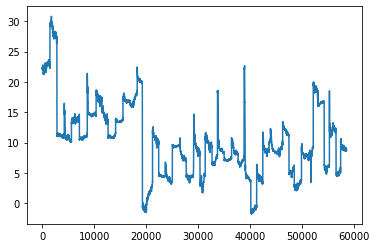

In [320]:
plt.plot(Fin['Temp'])